In [95]:
var('x a')

# interval arithmetics are used to take into account the numerical errors
R = RIF
PR = PolynomialRing(R, 'x')

maxx = R(1 / 20) # alpha = 11 * pi / 24 + x, where -maxx <= x <= maxx

n = 10
# split segment [-maxx, maxx] into n equal parts
dom = [[-maxx + i * 2 * maxx / n, -maxx + (i + 1) * 2 * maxx / n] for i in range(n)]
# mid[i] is the middle point of i-th part
mid = [sum(b) / R(2) for b in dom]

# given polynomials p[0], p[1], such that p[0](x) <= p[1](x) on [-maxx / n, maxx / n],
# return polynomials np[0], np[1] of degree <= 2,
# such that np[0](x) <= p[0](x) <= p[1](x) <= np[1](x) on [-maxx / n, maxx / n]
def reduceDegree(p):
    if p[0].degree(x) <= 2 and p[1].degree(x) <= 2:
        return p
    assert(p[0].degree(x) > 2 and p[1].degree(x) > 2)
    l = [p[0].list(), p[1].list()]
    for d in range(3, len(l[0])):
        l[0][2] -= abs(l[0][d]) * (maxx / n) ^ (d - 2)
    for d in range(3, len(l[1])):
        l[1][2] += abs(l[1][d]) * (maxx / n) ^ (d - 2)
    return [PR(l[0][:3]), PR(l[1][:3])]

# given polynomial p of degree <= 2, return an array of points,
# which contains argmax and argmin of p on [-maxx / n, maxx / n]
def getInterestingPoints(p):
    assert(p.degree(x) <= 2)
    if p.degree(x) < 2:
        return [-maxx / n, maxx / n]
    c, b, a = p.list()
    e = -a / 2 * b
    if e <= -maxx / n or maxx / n <= e: # e is definitely outside [-maxx / n, maxx / n]
        return [-maxx / n, maxx / n]
    else:
        return [-maxx / n, e, maxx / n]
    
# estimation of the analytic function f(x) on the interval [-maxx, maxx]:
# for 0 <= i < n contains polynomials p[i][0], p[i][1] of order <= 2,
# such that p[i][0](x - mid[i]) <= f(x) <= p[i][1][i](x - mid[i]) on dom[i]
class Estimator:
    def __init__(self, p, f):
        self.p = p
        self.f = f
      
    def __add__(self, t):
        return Estimator([[self.p[i][j] + t.p[i][j] for j in range(2)] for i in range(n)],
                         self.f + t.f)
    
    def __sub__(self, t):
        return Estimator([[self.p[i][j] - t.p[i][1 - j] for j in range(2)] for i in range(n)],
                         self.f - t.f)
    
    def __neg__(self):
        return Estimator([[-self.p[i][1], -self.p[i][0]] for i in range(n)],
                         -self.f)
    
    # we multiply only estimations with nonnegative values in [-maxx, maxx]
    def __mul__(self, t):
        assert(self.getBounds()[0] >= 0 and t.getBounds()[0] >= 0)
        res = Estimator([[self.p[i][j] * t.p[i][j] for j in range(2)] for i in range(n)],
                        self.f * t.f)
        res.reduceDegree()
        return res
    
    def reduceDegree(self):
        for i in range(n):
            self.p[i] = reduceDegree(self.p[i])
        
    def transposed(self):
        return Estimator([self.p[i][::-1] for i in range(n)], self.f)
    
    # plot function f and its estimations;
    # plot difference between f and its estimations;
    # print bounds; additionally print bounds in degrees, if inDegs=True
    def print(self, inDegs=False):
        p = (sum([plot([self.p[i][0].subs(x=x - mid[i])], dom[i], color='blue',
                     legend_label=(None if i > 0 else 'p[0]')) for i in range(n)]) +
             sum([plot([self.p[i][1].subs(x=x - mid[i])], dom[i], color='red',
                     legend_label=(None if i > 0 else 'p[1]')) for i in range(n)]) +
             plot([self.f], [-maxx, maxx], color='green', legend_label='f'))
        p2 = (sum([plot([SR(self.p[i][0].subs(x=x - mid[i]) - self.f)], dom[i], color='blue',
                        legend_label=(None if i > 0 else 'p[0] - f')) for i in range(n)]) +
              sum([plot([SR(self.p[i][1].subs(x=x - mid[i]) - self.f)], dom[i], color='red',
                        legend_label=(None if i > 0 else 'p[1] - f')) for i in range(n)]))
        graphics_array((p, p2)).show(figsize=[10, 3])
        
        b = self.getBounds()
        print(b[0], b[1])
        if inDegs:
            print('in degrees:\n', b[0] * R(180 / pi), b[1] * R(180 / pi))

    # explicitly find b[i][0], b[i][1] such that b[i][0] <= p[i][0](x) <= p[i][1](x) <= b[i][1]
    # on the interval [-maxx / n, maxx / n];
    # if full=False, return min(b[i][0], 0 <= i < n), max(b[i][1], 0 <= i < n)
    def getBounds(self, full=False):
        b = [[None, None] for i in range(n)]
        b2 = [None, None]
        for i in range(n):
            for c in getInterestingPoints(self.p[i][0]):
                val = R(self.p[i][0].subs(x=c))
                b[i][0] = val if b[i][0] == None else b[i][0].min(val)
                b2[0] = val if b2[0] == None else b2[0].min(val)
            for c in getInterestingPoints(self.p[i][1]):
                val = R(self.p[i][1].subs(x=c))
                b[i][1] = val if b[i][1] == None else b[i][1].max(val)
                b2[1] = val if b2[1] == None else b2[1].max(val)
        return b if full else b2

# get the estimator for a constant or linear function f(x) = C
def E(C):
    return Estimator([[PR(PR(C).subs(x=x + mid[i])), PR(PR(C).subs(x=x + mid[i]))] for i in range(n)], PR(C))

# return Taylor approximations of a function from below and above
# in the form s(x) + rem(c) * x ^ 2 / 2, where b[0] <= c <= b[1];
# assume that rem is monotonous on [b[0], b[1]]
def getTaylor(s, rem, b):
    brem = [R(rem.subs(x=b[0])), R(rem.subs(x=b[1]))]
    res = [s + brem[0].min(brem[1]) * x ^ 2 / R(2),
           s + brem[0].max(brem[1]) * x ^ 2 / R(2)]
    return res

# substitute estimator e into Taylor approximations of function f
def subs(f, s, rem, e):
    b = e.getBounds(full=True)
    p = []
    for i in range(n):
        mid = sum(b[i]) / R(2)
        taylor = getTaylor(s, rem, b[i])
        p.append([PR(PR(taylor[j].subs(a=mid)).subs(x=e.p[i][j] - mid)) for j in range(2)])
    res = Estimator(p, f.subs(a=e.f))
    res.reduceDegree()
    return res

In [96]:
sinf = sin(x + a).series(x, 2).truncate()
sinrem = sin(x).derivative(x, 2)

# given estimator e of f(x), return the estimator of sin(f(x))
def mysin(e):
    b = e.getBounds()
    if pi / 2 < b[0] and b[1] < pi: # sin(x) = sin(pi - x)
        return mysin(E(pi) - e)
    assert(0 < b[0] and b[1] < pi / 2) # check that sinrem is monotonous on [b[0], b[1]]
    res = subs(sin(a), sinf, sinrem, e)
    return res

In [97]:
cosf = cos(x + a).series(x, 2).truncate()
cosrem = cos(x).derivative(x, 2)

# given estimator e of f(x), return the estimator of cos(f(x))
def mycos(e):
    b = e.getBounds()
    if pi / 2 < b[0] and b[1] < pi: # cos(x) = -cos(pi - x)
        return -mycos(E(pi) - e)
    assert(0 < b[0] and b[1] < pi / 2)  # check that cosrem is monotonous on [b[0], b[1]]
    res = subs(cos(a), cosf, cosrem, e.transposed()) # cos is decreasing on (0, pi / 2)
    return res

In [98]:
acosf = acos(x + a).series(x, 2).truncate()
acosrem = acos(x).derivative(x, 2)

# given estimator e of f(x), return the estimator of acos(f(x))
def myacos(e):
    b = e.getBounds()
    assert(0 < b[0] and b[1] < 1) # check that acos is defined on [b[0], b[1]]
    res = subs(acos(a), acosf, acosrem, e.transposed()) # acos is decreasing
    return res

In [99]:
invf = (1 / (x + a)).series(x, 2).truncate()
invrem = (1 / x).derivative(x, 2)

# given estimator e of f(x), return the estimator of 1 / f(x)
def myinv(e):
    b = e.getBounds()
    assert(0 < b[0]) # check that inverse function is defined on [b[0], b[1]]
    res = subs(1 / a, invf, invrem, e.transposed()) # 1 / x is decreasing when x > 0
    return res

In [100]:
sqrtf = sqrt(x + a).series(x, 2).truncate()
sqrtrem = sqrt(x).derivative(x, 2)

# sqrtf[0](x, a) <= sqrt(x + a) <= sqrtf[1](x, a) for sqrtb < a, sqrtb < x + a < 2 * a

def mysqrt(e):
    b = e.getBounds()
    assert(0 < b[0]) # check that sqrt is defined on [b[0], b[1]]
    res = subs(sqrt(a), sqrtf, sqrtrem, e)
    return res

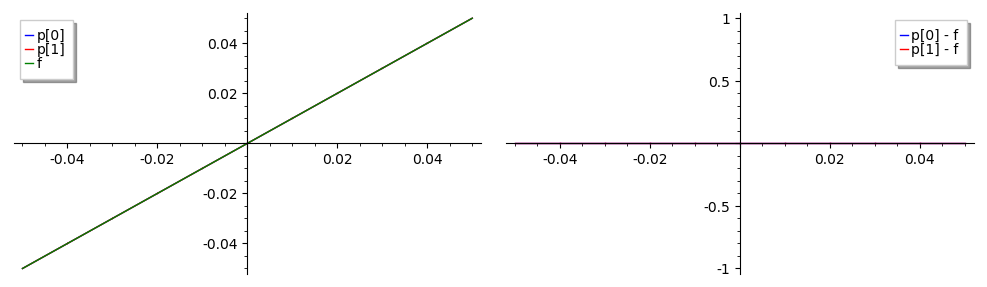

-0.0500000000000000? 0.0500000000000000?


In [101]:
dalpha = E(x)
dalpha.print()

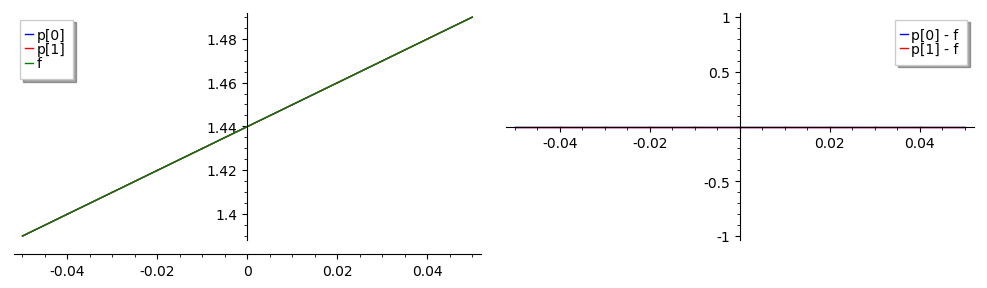

1.389896632895322? 1.489896632895322?
in degrees:
 79.6352110243459? 85.3647889756541?


In [102]:
alpha = E(11 * pi / 24) + dalpha
alpha.print(inDegs=True)

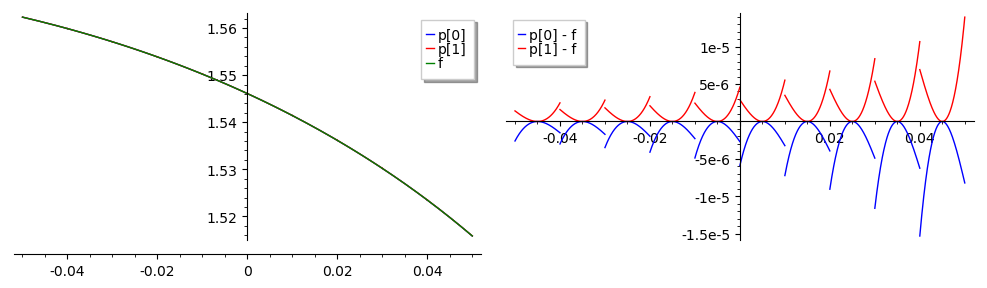

1.5158524860917? 1.56230281681592?
in degrees:
 86.851949817464? 89.513357724952?


In [103]:
q = alpha - E(pi / 12) + myacos(E(1) - mysin(E(2) * alpha)) * E(1 / 2)
q.print(inDegs=True)

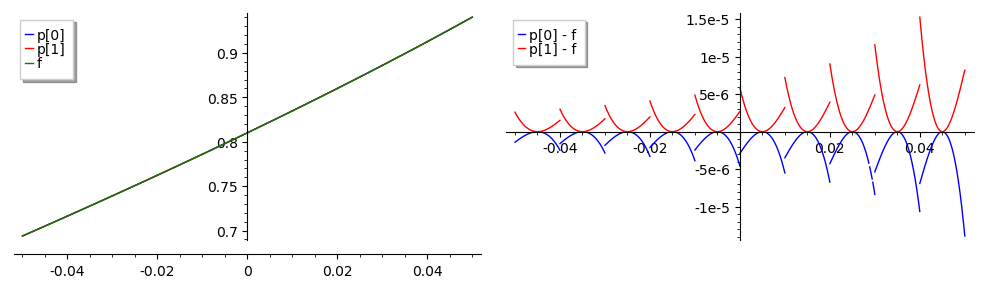

0.69389167337643? 0.94034200410071?
in degrees:
 39.757064323740? 53.877628133844?


In [104]:
gamma = alpha - E(pi / 12) - myacos(E(1) - mysin(E(2) * alpha)) * E(1 / 2)
gamma.print(inDegs=True)

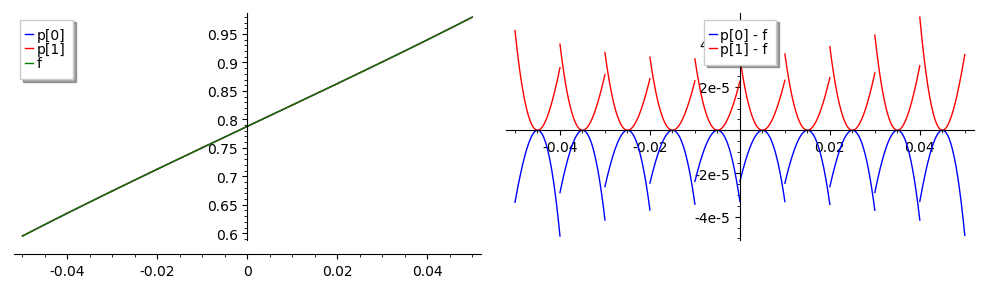

0.595159944672? 0.979655297870?
in degrees:
 34.1001529650? 56.1301139456?


In [105]:
t = myacos(E(1) + mycos(E(2) * alpha) - mycos(E(2 * pi / 3) - E(2) * alpha + E(2) * q))
t.print(inDegs=True)

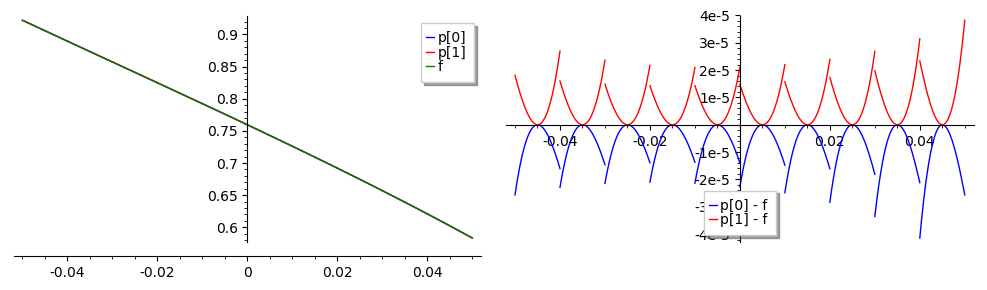

0.583325755458? 0.922023762782?
in degrees:
 33.42210386901? 52.82807021814?


In [106]:
delta = E(pi / 3) - alpha + q - t * E(1 / 2)
delta.print(inDegs=True)

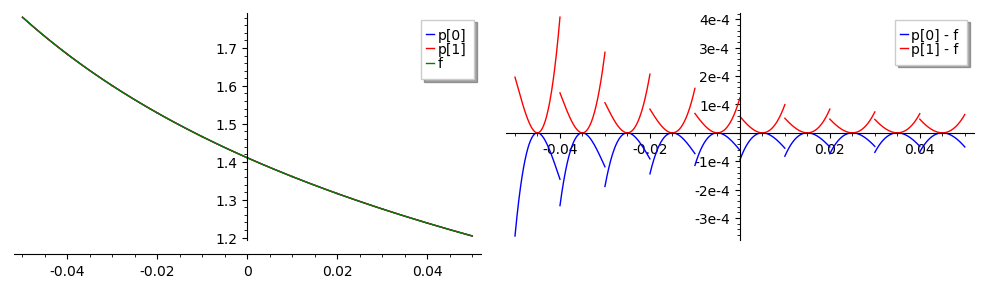

1.20431804886? 1.78121898335?


In [107]:
X = mysin(t + delta) * myinv(mysin(t))
X.print()

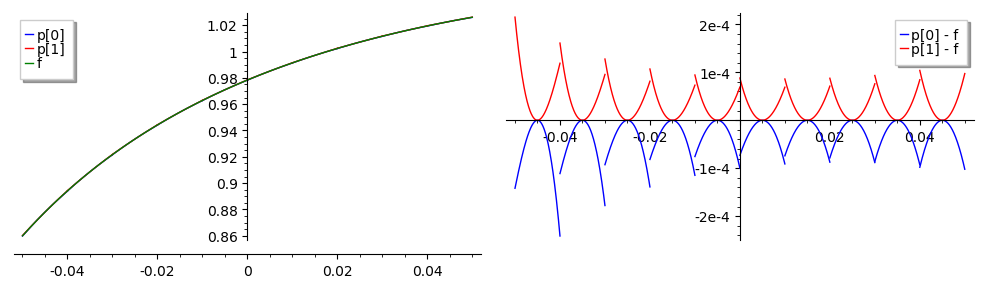

0.85981483704? 1.026153956603?


In [108]:
YnumR = E(1) - mysin(delta) * mysin(gamma) * mycos(t) * myinv(mysin(t)) + mysin(delta) * mycos(gamma)
YnumR.print()

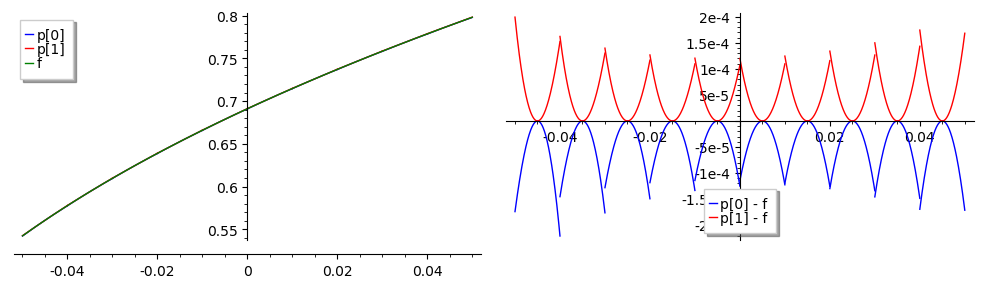

0.54209504426? 0.79831911670?


In [109]:
Ynum = mycos(t + E(2) * delta - E(pi / 2)) * YnumR - (mysin(delta) + mycos(gamma)) * mycos(q)
Ynum.print()

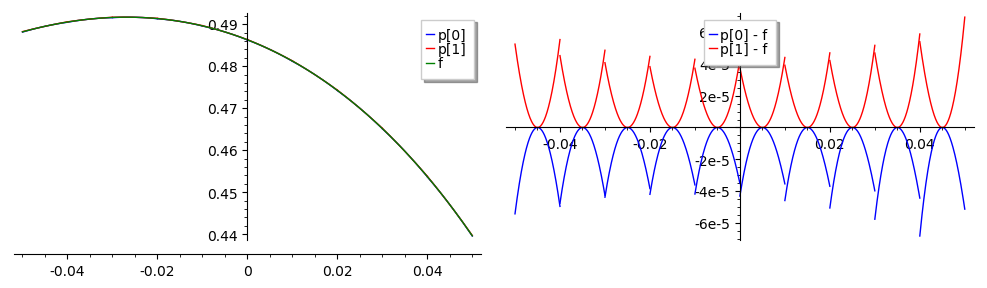

0.439590945740? 0.491632213604?


In [110]:
Yden = mycos(t + E(2) * delta - E(pi / 2)) * mycos(gamma) - mycos(q)
Yden.print()

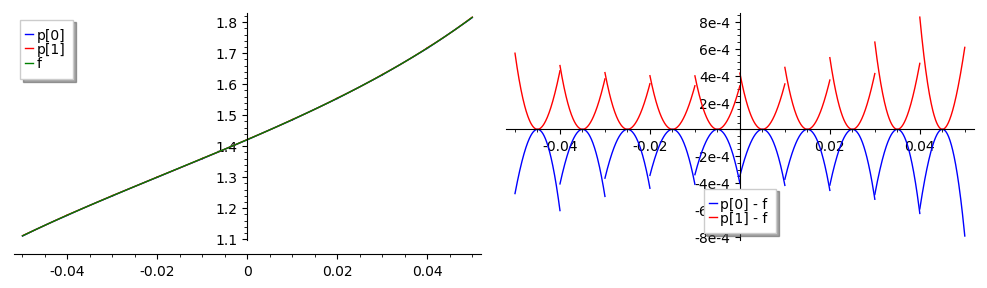

1.11036942566? 1.8160645004?


In [111]:
Y = Ynum * myinv(Yden)
Y.print()

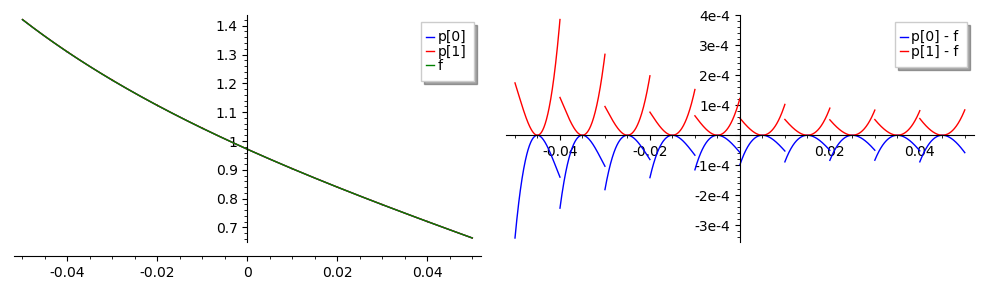

0.66335707767? 1.42136167881?


In [112]:
AQ1 = mysin(delta) * myinv(mysin(t))
AQ1.print()

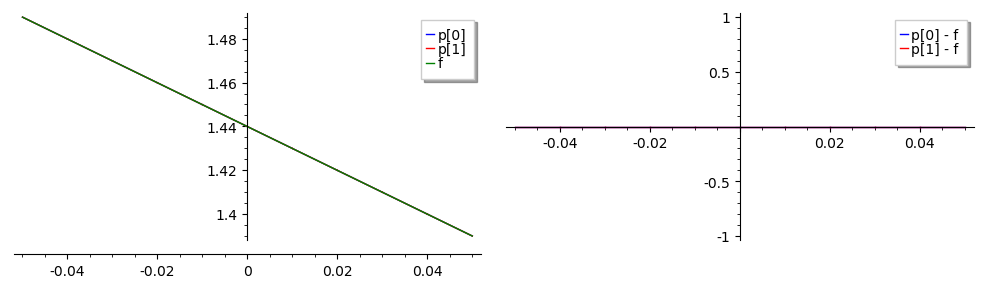

1.389896632895322? 1.489896632895322?
in degrees:
 79.6352110243459? 85.3647889756541?


In [113]:
beta = (E(11 * pi / 12) - alpha)
beta.print(inDegs=True)

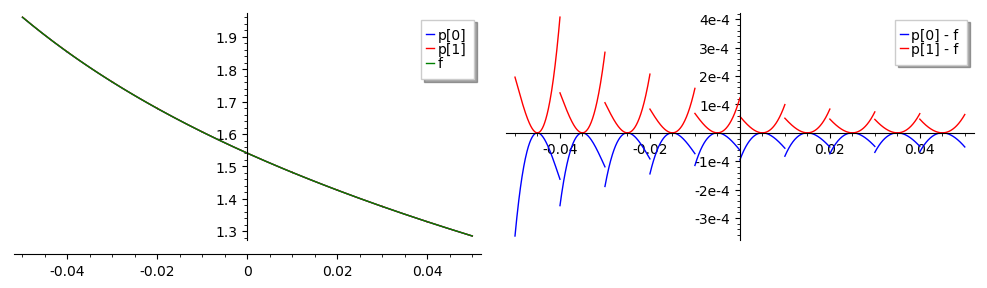

1.28512944376? 1.96113372444?


In [114]:
W1x = X + mycos(alpha)
W1x.print()

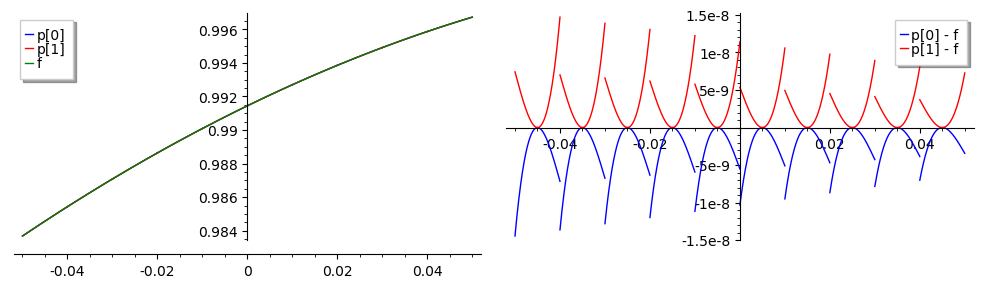

0.983682208354535? 0.996729411398779?


In [115]:
W1y = mysin(alpha)
W1y.print()

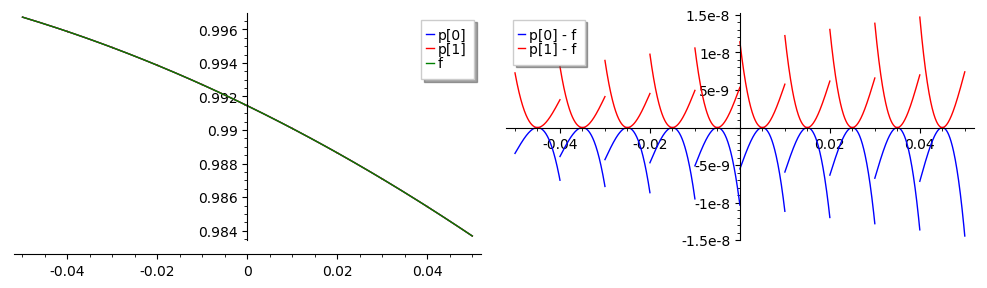

0.98368220835454? 0.996729411398779?


In [116]:
W2x = mysin(beta)
W2x.print()

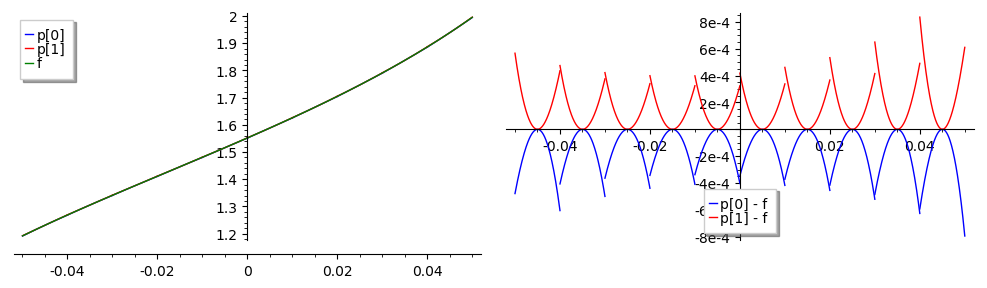

1.1911808206? 1.9959792415?


In [117]:
W2y = Y + mycos(beta)
W2y.print()

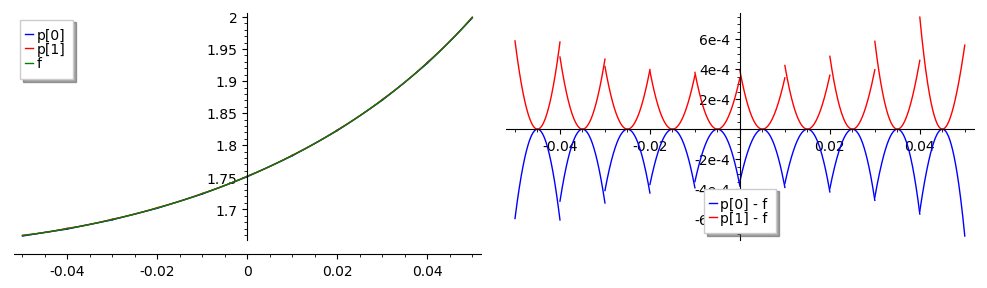

1.65835099673? 1.99983870013?


In [118]:
Sx = W2x + (W1x - W2x) * E(cos(pi / 3)) + (W2y - W1y) * E(sin(pi / 3))
Sx.print()

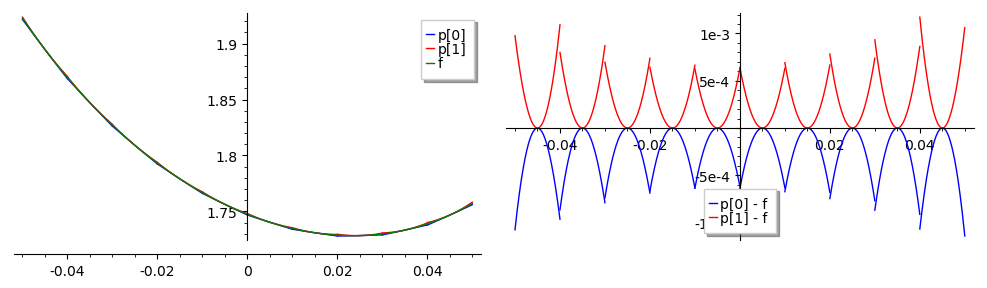

1.7279984820? 1.9236747512?


In [119]:
Sy = W2y + (W1x - W2x) * E(sin(pi / 3)) - (W2y - W1y) * E(cos(pi / 3))
Sy.print()

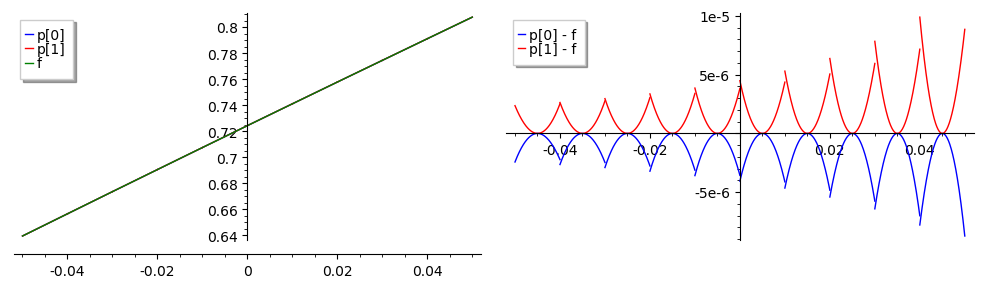

0.6395324446347? 0.8077637815980?


In [120]:
Q2x = mysin(gamma)
Q2x.print()

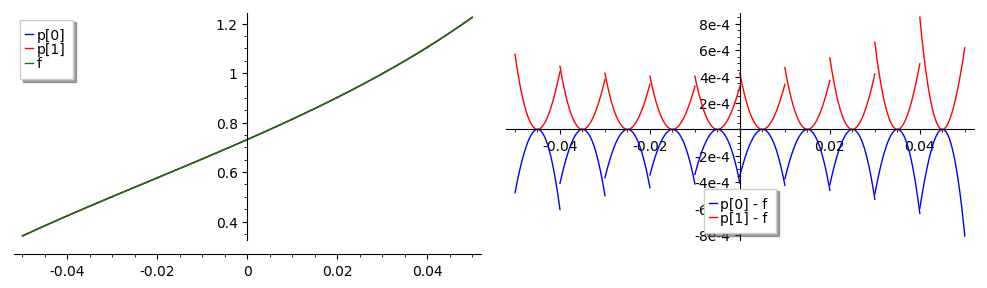

0.34160582603? 1.2265540990?


In [121]:
Q2y = Y - mycos(gamma)
Q2y.print()

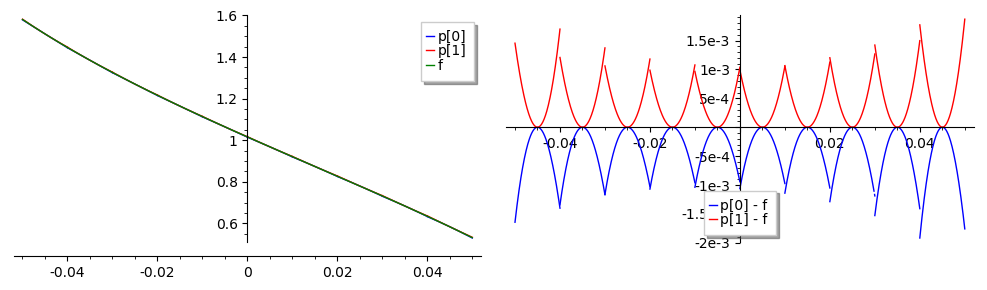

0.5294572245? 1.5820689251?


In [122]:
dotprod = Sy - Q2y
dotprod.print()

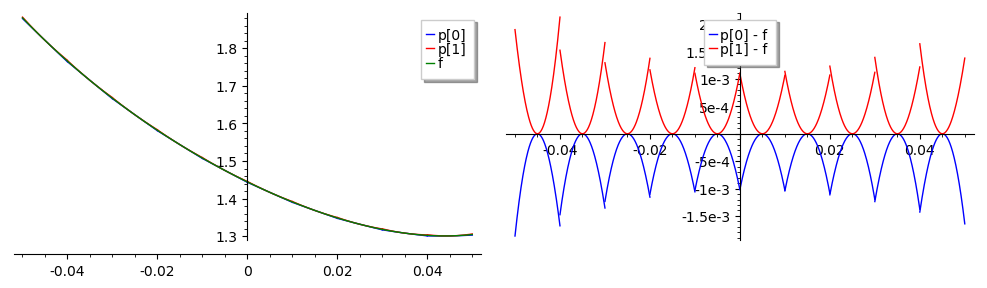

1.3007640407? 1.882734331?


In [123]:
SQ2 = mysqrt((Sx - Q2x) * (Sx - Q2x) + (Sy - Q2y) * (Sy - Q2y))
SQ2.print()

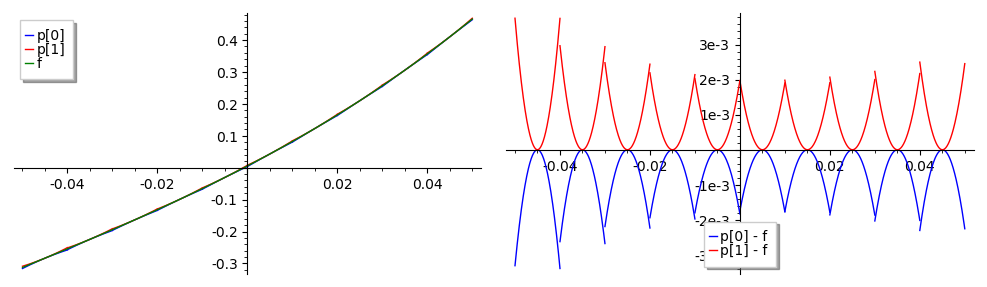

-0.315894665? 0.468475926?
in degrees:
 -18.0994311? 26.8416934?


In [124]:
diff = myacos(dotprod * myinv(SQ2)) + E(2 * pi / 3) - E(2) * beta
diff.print(inDegs=True)

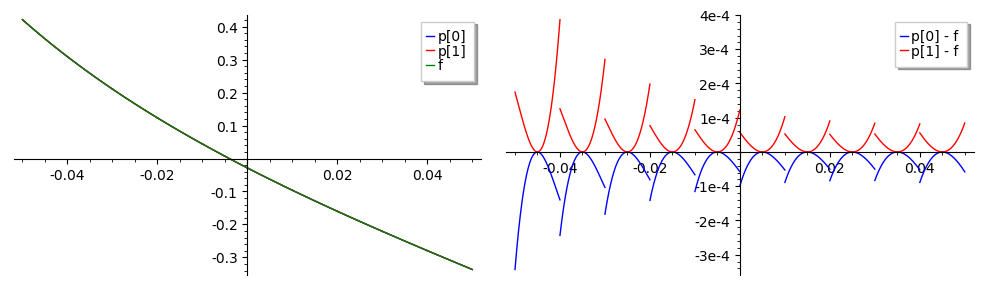

-0.33664292233? 0.42136167881?


In [125]:
(AQ1 - E(1)).print()

In [127]:
cond1 = [diff.p[i][1] for i in range(n)]
# we know that diff = 0, so cond1 >= 0 should hold
cond2 = [(AQ1 - E(1)).p[i][1] for i in range(n)]
# we know that AQ1 > 1, so cond2 >= 0 should hold

In [93]:
# solve p(x) >= 0, -maxx <= x <= maxx,
# where p(x) = ax^2 + bx + c, a > 0
def mysolve(p, maxx):
    assert(p.degree(x) == 2)
    c, b, a = p.list()
    assert(a > 0)
    D2 = b ^ 2 - 4 * a * c
    if D2 < 0:
        return [R(-maxx, maxx)]
    assert(D2 >= 0)
    D = sqrt(D2)
    roots = [(-b - D) / 2 / a, (-b + D) / 2 / a]
    sols = []
    if roots[0] >= maxx or roots[1] <= -maxx:
        return [R(-maxx, maxx)]
    if not(roots[0] <= -maxx):
        sols.append(R(-maxx, roots[0]))
    if not(roots[1] >= maxx):
        sols.append(R(roots[1], maxx))
    return sols

# solve inequalities cond1 >= 0 and cond2 >= 0
def mysolveP(cond):
    presols = []
    for i in range(n):
        tmp = [(_ + mid[i]) for _ in mysolve(cond[i], maxx / n)]
        presols.extend(tmp)
    sols = []
    for p in presols:
        if len(sols) == 0:
            sols.append(p)
            continue
        if sols[-1].overlaps(p):
            sols[-1] = sols[-1].union(p)
        else:
            sols.append(p)
    return sols

print([_.str(style='brackets') for _ in mysolveP(cond1)])
print([_.str(style='brackets') for _ in mysolveP(cond2)])
print(mysolveP(cond1)[0].overlaps(mysolveP(cond2)[0]))

['[-0.00093947326225162376 .. 0.050000000000000038]']
['[-0.050000000000000010 .. -0.0040303448408811320]']
False
